In [27]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV,Lasso, LassoLarsCV, LinearRegression,RANSACRegressor
from sklearn.model_selection import cross_val_score,KFold,train_test_split,cross_val_predict, StratifiedKFold
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import *
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from pandas.tools.plotting import scatter_matrix
import statsmodels.formula.api as sm
from scipy.stats import norm
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
import datetime 
from  datetime  import datetime as dt 
from scipy import stats
import operator
from sklearn import cross_validation, grid_search, linear_model, metrics

from sklearn.feature_selection import VarianceThreshold
import re
import warnings 
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [28]:
data = pd.read_csv('dataset100717.csv', sep=';') #
data = data.loc[data.IS_FIRST==0]
agg68 = pd.read_csv('done686.csv', sep=';') 
agg68.drop([x for x in agg68.columns if x.endswith('_median')], inplace=1, axis =1)

data = data.loc[(data['TMP_STP_ALL_AVG']>360)&(data['TMP_STP_ALL_AVG']<700)&(data.TEMP_START_PHASE1!=0)&((data.ADAPTATION_KEY==190409109015)|(data.ADAPTATION_KEY==190309109015))]

data.drop(['TMP_STRT_HED_AVG_M','TMP_STRT_TAIL_AVG_M', 'PROFILE_SDV', u'PROFILE_MIN', u'PROFILE_AVG', u'PROFILE_MAX'], axis=1, inplace=True)
data = data.dropna()

In [29]:
data['Vol'] = data['PLT_TCK']*data['PLT_WID']*data['PLT_LEN']*1e-09
data['MEAS_TIME'] = data['MEAS_TIME'].apply(lambda x: dt.strptime(x, "%d.%m.%y %H:%M:%S"))
data['PREV_MEAS_TIME'] = data['PREV_MEAS_TIME'].apply(lambda x: dt.strptime(x, "%d.%m.%y %H:%M:%S"))

data['hour'] = 0
data['hour'] = data['MEAS_TIME'].apply(lambda x: x.hour)


data['diff_mins'] = data['MEAS_TIME'] - data['PREV_MEAS_TIME']
data['diff_mins'] = data['diff_mins'].apply(lambda x: round(x.total_seconds()/60,2))
# data['weekday'] = data['MEAS_TIME'].apply(lambda x: x.weekday())

data['prev_fail'] = data['NOT_IN_25_0C'].shift().fillna(0) 
data['CR_PREV'] = (data['CR_ACT'] - data['CR']).shift().fillna((data['CR_ACT'] - data['CR']).median())  
data['TMP_STP_ALL_PREV'] = data['TMP_STP_ALL_AVG'].shift().fillna(data.TMP_STP_ALL_AVG.median())  

data['ADAPT_TS_MEAN_PREV'] = data['ADAPT_TS_MEAN'].shift().fillna(data.ADAPT_TS_MEAN.median())  

data['ADAPT_CR_PREV'] = data['ADAPT_CR'].shift().fillna(data.ADAPT_CR.median())  

data['daypart'] = 0
data.ix[(data.hour>8)&(data.hour<=12), 'daypart'] = 1
data.ix[(data.hour>12)&(data.hour<=16), 'daypart'] = 2
data.ix[(data.hour>16)&(data.hour<=20), 'daypart'] = 3
data.ix[(data.hour>20)&(data.hour<=23), 'daypart'] = 4



for col in [u'WATER_FLOW_SPRAY_TOP', u'WATER_FLOW_SPRAY_BOTTOM']:
    data[col] = data[col].apply(lambda x: x.split('|'))
    data.ix[data[col].apply(lambda x: len(x))>4, col] = data[col].apply(lambda s: map('.'.join, zip(s[::2], s[1::2])))
    
for col in [ u'WATER_FLOW_LAM_INNER_TOP', u'WATER_FLOW_LAM_OUTER_TOP',
       u'WATER_FLOW_LAM_INNER_BOT', u'WATER_FLOW_LAM_OUTER_BOT']:
    data[col] = data[col].apply(lambda x: x.split('|'))
    data.ix[data[col].apply(lambda x: len(x))>36, col] = data[col].apply(lambda s: map('.'.join, zip(s[::2], s[1::2])))
    
for col in [ 'EDGE_MASKING_POS_DRIVE_SIDE', 'EDGE_MASKING_POS_OP_SIDE', 'BANKS_HEIGHT']:
    data[col] = data[col].apply(lambda x: x.split('|'))
    data.ix[data[col].apply(lambda x: len(x))>9, col] = data[col].apply(lambda s: map('.'.join, zip(s[::2], s[1::2])))
    
    
for col in [u'WATER_FLOW_SPRAY_TOP', u'WATER_FLOW_SPRAY_BOTTOM', u'WATER_FLOW_LAM_INNER_TOP', u'WATER_FLOW_LAM_OUTER_TOP',
       u'WATER_FLOW_LAM_INNER_BOT', u'WATER_FLOW_LAM_OUTER_BOT','EDGE_MASKING_POS_DRIVE_SIDE', 'EDGE_MASKING_POS_OP_SIDE', 'BANKS_HEIGHT'] :
    data[col] = data[col].apply(lambda x: [float(i) for i in x])
    

    
for col in [u'WATER_FLOW_SPRAY_TOP', u'WATER_FLOW_SPRAY_BOTTOM', u'WATER_FLOW_LAM_INNER_TOP', u'WATER_FLOW_LAM_OUTER_TOP',
       u'WATER_FLOW_LAM_INNER_BOT', u'WATER_FLOW_LAM_OUTER_BOT','EDGE_MASKING_POS_DRIVE_SIDE', 'EDGE_MASKING_POS_OP_SIDE', 'BANKS_HEIGHT'] :
    data[col] = data[col].apply(lambda x: np.mean(x))
    
    
    
for col in ['SIDE_SPRAY', 'AIR_BLOWER'] :
    data[col] = data[col].apply(lambda x: str(x.count('0')))
    


agg68.rename(columns={'pltid':'PIECE_ID'}, inplace=1)

df = pd.merge(agg68, data, on='PIECE_ID')    



# df['outcome'] = 0
# df.ix[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG>510), 'outcome']=1

# df.ix[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG<450), 'outcome']=2

# df.ix[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG>480), 'outcome']=1

# df.ix[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG<480),'outcome']=2

flowsum_cols = [x for x in df.columns if ('flow' in x or 'SpecFlw' in x ) and ('sum' in x or 'SUM' in x)]
df[flowsum_cols] = df[flowsum_cols].apply(lambda x: (x/60)*df['time'])
df.fillna(0, axis=1, inplace=1)

flow_cols = [x for x in data.columns if 'Flw' in x and ('WatAbs' not in x) and ('Ratio' not in x)]

df['Specflow_bot_sum_diff'] =  df['SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_mean'] - df[ 'SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_task_mean']
df['Specflow_top_sum_diff'] = df['SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_mean'] - df['SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_task_mean']

df['BHC_cen_flow_diff'] = df['BHC_cen_flow_sum_act_mean'] - df['BHC_flow_cen_sum_task_mean']
df['BHC_out_flow_diff'] = df[ 'BHC_out_act_sum_mean'] - df[ 'BHC_flow__out_sum_task_mean']
df[ 'THC_cen_flow_diff'] = df['THC_cen_flow_sum_act_mean'] - df['THC_flow_cen_sum_task_mean']
df['THC_out_flow_mean'] = df['THC_out_flow_sum_act_mean'] - df['THC_out_flow_sum_task_mean']

In [30]:
todrop = ['GFC.Ai._aiGfcPrsAirBlw_mean', 'GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiTmpWatScc_ActV_mean','GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioSetMod_ActV_mean',
        'GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwTop_SetV_mean',
 'GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskLenTop_SetV_mean',
 'GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwBot_SetV_mean',
 'GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskLenBot_SetV_mean',
 'GFC._Hmi2Gfc.Hmi2Gfc.GfcTailMskFlwTop_SetV_mean',
 'GFC._Hmi2Gfc.Hmi2Gfc.GfcTailMskFlwBot_SetV_mean', 'THC._ThcRtData.ThcRtData.WatAbsFlwSum_mean', 
         'PRC.GlobVar.PrcLocRtData.PrcPosMean_mean',

 'EMC.GlobVar.EmcLocRtData.Mot_PosMean_mean',
 'EMC.GlobVar.EmcLocRtData.Mot_Pos_DsOsdiff_sum_mean',
 'EMC.GlobVar.EmcLocRtData.Mot_PosDiff_sum_mean', 'dist_from_plt_sum_mean', 'PPS_PIECE_ID',
 'PREV_PIECE_ID',
 'PIECE_ID_1',
 'PIECE_ID_2','PLT_TCK',
 'PLT_WID',
 'PLT_LEN','Vol', 'TMP_STP_HEAD_AVG',
 'TMP_STP_HEAD_MIN',
 'TMP_STP_HEAD_MAX',
 'TMP_STP_HEAD_DEV',
 'TMP_STP_BDY_AVG',
 'TMP_STP_BDY_MIN',
 'TMP_STP_BDY_MAX',
 'TMP_STP_BDY_DEV',
 'TMP_STP_TAIL_AVG',
 'TMP_STP_TAIL_MIN',
 'TMP_STP_TAIL_MAX',
 'TMP_STP_TAIL_DEV',
 'TMP_STP_ALL_MIN',
 'TMP_STP_ALL_MAX',
 'TMP_STP_ALL_DEV','CR_ACT', 'DIF_TMP_ALL','CR',
 'DEF_CR', 'DIF_STRT_HED_AVG',
 'DIF_STRT_TAIL_AVG',
 'DIF_STRT_TOT','PODKAT',
 'PODKAT2', 'TEMP_START_PHASE2','HEATING_TIME',
          'TMP_STRT_TOT_AVG_M',
 'TMP_STRT_BDY_AVG_M','TMP_STA_TOT_MIN_M', 'TMP_STRT_BDY_AVG','TMP_STRT_ALL_AVG', 'TMP_STRT_TOT_MAX_M',
           'THC_out_degree_sum_act_mean',

 'TMP_STRT_ALL_MIN',
 'TMP_STRT_BDY_MIN','L_ACC',
'hour',
 'UNIFORMITY',
 'BATCH_SIZE',
 'TEMP_OVERHEATING', 'WBF_NO', 'FURT10',
 'FURT40','AVG_MASS_TEMP','CR_HEAD', 'SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_mean','EDGE_MASKING_POS_DRIVE_SIDE',
 'EDGE_MASKING_POS_OP_SIDE',

 'CR_BDY','WATER_FLOW_SPRAY_TOP',
 'WATER_FLOW_SPRAY_BOTTOM',
 'WATER_FLOW_LAM_INNER_TOP',
 'WATER_FLOW_LAM_OUTER_TOP',
 'WATER_FLOW_LAM_INNER_BOT','TFM',
 'TS',
    
 'WATER_FLOW_LAM_OUTER_BOT', 'ADAPT_CR_PREV',
 'CR_TAIL',
 'CR_SPRAY_HEAD',
 'CR_SPRAY_BDY',
 'CR_SPRAY_TAIL',
 'CR_LAM_HEAD',
 'CR_LAM_BDY',
          'BHC_out_act_degree_sum_mean', 'THC_out_degree_sum_act_mean', 'HEAD_MASKING_TOP_LENGTH',
 'HEAD_MASKING_TOP_FLOW', 'TAIL_MASKING_TOP_LENGTH', 'HEAD_MASKING_BOTTOM_LENGTH',
 'HEAD_MASKING_BOTTOM_FLOW',u'TMP_STRT_BDY_MAX','TMP_STRT_TAIL_MAX',u'TMP_STRT_TAIL_MIN',u'TMP_STRT_BDY_DEV',u'TMP_STRT_ALL_MAX', 'TMP_STRT_HEAD_AVG',u'TMP_STRT_TAIL_AVG',u'TMP_STRT_HEAD_MIN', u'TMP_STRT_HEAD_DEV', 
 'TAIL_MASKING_TOP_FLOW','TOP_FLW_SCS',
 'TAIL_MASKING_BOTTOM_LENGTH',
 'TAIL_MASKING_BOTTOM_FLOW',  'BANKS_HEIGHT', 'MEAS_TIME',u'DIF_SPRAY_BDY_HEAD', u'DIF_SPRAY_BDY_TAIL',
  u'DIF_LAM_BDY_TAIL',
 'PREV_MEAS_TIME',
 'SIDE_SPRAY',
 'AIR_BLOWER',
        u'PLT_COOL_SPD_AVG', u'PLT_COOL_SPD_HEAD_AVG',
 'NOT_IN_40_0C',
 'IS_FIRST',
 'WATER_TEMP_LAMINAR_COOLING', 'NOT_ANALYSIS',u'DIF_BDY_TAIL', u'DIF_BDY_HEAD',   u'SPEED',  u'DIF_LAM_BDY_HEAD',

 'CR_LAM_TAIL']

df.drop([x for x in df.columns if 'mean_mean' in x  or 'mean_act_mean' in x or 'mean_task_mean' in x or 'task' in x or x in todrop], axis=1, inplace=1)

In [31]:
for col in [
 'ADAPTATION_KEY',
'HEADERS',
'WBF_COL_NO',
 'BATCH_POSITION','ADAPTION_KEY_CHANGED',
'daypart']:
    df[col] = df[col].apply(lambda x: str(x))

In [32]:
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']
numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object' and c not in ['NOT_IN_25_0C','TMP_STP_ALL_AVG','PIECE_ID','prev_fail','outcome']]
print 'Categorical columns:\n', categorical_columns, '\n\n',
print 'Numerical columns:\n', numerical_columns

Categorical columns:
['ADAPTATION_KEY', 'HEADERS', 'WBF_COL_NO', 'BATCH_POSITION', 'ADAPTION_KEY_CHANGED', 'daypart'] 

Numerical columns:
['time', 'GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiTmpWatLpc_ActV_mean', 'GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiGenWtsAirTmp_ActV_mean', 'GFC.Ai._aiGfcAirPrs_mean', 'GFC.GlobVar.GfcLocRtData.GfcSccWatPrsScc_mean', 'BHC._BhcRtData.BhcRtData.WatAbsFlwSum_mean', 'PRC.GlobVar.PrcLocRtData.PrcPos_DsOsdiff_sum_mean', 'PRC.GlobVar.PrcLocRtData.PrcPosDiff_sum_mean', 'SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_mean', 'BHC_cen_act_degree_sum_mean', 'BHC_cen_flow_sum_act_mean', 'BHC_out_act_sum_mean', 'THC_cen_act_degree_sum_mean', 'THC_cen_flow_sum_act_mean', 'THC_out_flow_sum_act_mean', 'RES_TIM_STRT_COMPL', 'TMP_STRT_HEAD_MAX', 'TMP_STRT_TAIL_DEV', 'TMP_STRT_ALL_DEV', 'PLT_COOL_SPD_TAIL_AVG', 'PLT_ACCELERATION', 'ADAPT_CR', 'ADAPT_TS_MEAN', 'TOP_FLW_LPC', 'DURATION_IN_HOLDING_ZONE', 'TEMP_START_PHASE1', 'TEMP_END_PHASE2', 'DIF_TEMP_START', 'DIF_TFM', 'DIF_STRT_TOT_AVG', 'DIF_BDY_HEAD

In [33]:
data_describe = df.describe(include=[object])

binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]

print binary_columns, nonbinary_columns

['ADAPTATION_KEY', 'HEADERS', 'WBF_COL_NO', 'ADAPTION_KEY_CHANGED'] ['BATCH_POSITION', 'daypart']


In [34]:
df.HEADERS.value_counts()

22    789
23    234
Name: HEADERS, dtype: int64

In [35]:
for c in binary_columns:
    top = data_describe[c]['top']
    top_items = df[c] == top
    df.loc[top_items, c] = 0
    df.loc[np.logical_not(top_items), c] = 1
    
data_nonbinary = pd.get_dummies(df[nonbinary_columns])

In [36]:
data_numerical = df[numerical_columns]
# data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()
# data_numerical.describe()

In [37]:
X =  pd.concat((data_numerical,data_nonbinary,df[binary_columns]), axis=1)
X_test= pd.DataFrame(X, dtype=float)
y_test = df.TMP_STP_ALL_AVG
y_class_test = df['NOT_IN_25_0C']
print( X_test.shape)
print (X_test.columns)

(1023, 55)
Index([u'time', u'GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiTmpWatLpc_ActV_mean',
       u'GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiGenWtsAirTmp_ActV_mean',
       u'GFC.Ai._aiGfcAirPrs_mean',
       u'GFC.GlobVar.GfcLocRtData.GfcSccWatPrsScc_mean',
       u'BHC._BhcRtData.BhcRtData.WatAbsFlwSum_mean',
       u'PRC.GlobVar.PrcLocRtData.PrcPos_DsOsdiff_sum_mean',
       u'PRC.GlobVar.PrcLocRtData.PrcPosDiff_sum_mean',
       u'SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_mean',
       u'BHC_cen_act_degree_sum_mean', u'BHC_cen_flow_sum_act_mean',
       u'BHC_out_act_sum_mean', u'THC_cen_act_degree_sum_mean',
       u'THC_cen_flow_sum_act_mean', u'THC_out_flow_sum_act_mean',
       u'RES_TIM_STRT_COMPL', u'TMP_STRT_HEAD_MAX', u'TMP_STRT_TAIL_DEV',
       u'TMP_STRT_ALL_DEV', u'PLT_COOL_SPD_TAIL_AVG', u'PLT_ACCELERATION',
       u'ADAPT_CR', u'ADAPT_TS_MEAN', u'TOP_FLW_LPC',
       u'DURATION_IN_HOLDING_ZONE', u'TEMP_START_PHASE1', u'TEMP_END_PHASE2',
       u'DIF_TEMP_START', u'DIF_TFM', u'DIF_STRT_TOT_AVG', 

In [38]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 111)

# N_train, _ = X_train.shape 
# N_test,  _ = X_test.shape 
# print N_train, N_test

In [39]:
X_train = pd.read_csv('old_train.csv', sep = ';')
y_train = pd.read_csv('old_ytrain.csv', sep = ';')
y_class_train = pd.read_csv('old_y_class_train.csv', sep = ';')

X_train.rename(columns={'HEADERS_23':'HEADERS'}, inplace=1)

X_train = X_train[X_test.columns]

In [878]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',264)

pd.concat([X_train.mean(), X_test.mean()], axis=1)

,0,1
time,61.766,63.726
GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiTmpWatLpc_ActV_mean,20.733,21.511
GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiGenWtsAirTmp_ActV_mean,13.756,22.375
GFC.Ai._aiGfcAirPrs_mean,5.304,5.507
GFC.GlobVar.GfcLocRtData.GfcSccWatPrsScc_mean,4.378,4.376
BHC._BhcRtData.BhcRtData.WatAbsFlwSum_mean,2775.013,2624.109
PRC.GlobVar.PrcLocRtData.PrcPos_DsOsdiff_sum_mean,0.230,0.235
PRC.GlobVar.PrcLocRtData.PrcPosDiff_sum_mean,1.255,1.098
SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_mean,5006.372,4914.525
BHC_cen_act_degree_sum_mean,325.523,306.913


In [879]:
1.*y_class_train.sum()/len(y_class_train)

NOT_IN_25_0C   0.027
dtype: float64

In [880]:
1.*y_class_test.sum()/len(y_class_test)

0.03812316715542522

In [40]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)


# The mean squared error`
print "Root mean squared error: %.2f", mean_absolute_error( y_test, lr_pred)**0.5
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lr.score(X_test, y_test))
print 'R^2 score: %.2f' % r2_score(y_test, lr_pred,multioutput='uniform_average')

Root mean squared error: %.2f 2.53373071682
Variance score: 0.54
R^2 score: 0.54


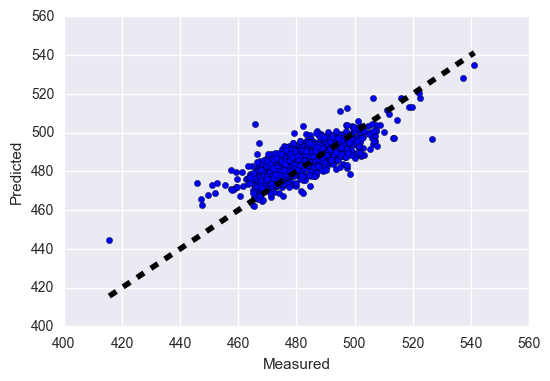

In [41]:
fig, ax = plt.subplots()
ax.scatter(y_test, lr_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [42]:
y_cl = lr_pred.copy()

y_cl[y_cl>505] = 1
y_cl[y_cl<455] = 1

y_cl[(y_cl<=505)&(y_cl>=455)&(y_cl!=1)] = 0

y_t = y_test.copy()

y_t[y_t>505] = 1
y_t[y_t<455] = 1

y_t[(y_t<=505)&(y_t>=455)&(y_t!=1)] = 0



In [43]:
print "Roc-auc: %.2f" %  roc_auc_score(y_t,y_cl) , '\n'
print "Confusion matrix: \n", confusion_matrix(y_t,y_cl), "\n"
print "F1 score: %.2f" % f1_score(y_t,y_cl), "\n"
print "Recall: %.2f" %  recall_score(y_t,y_cl), "\n"
print "Precision score: %.2f" % precision_score(y_t,y_cl), "\n"
print "Accuracy: " ,accuracy_score(y_t,y_cl)

Roc-auc: 0.65 

Confusion matrix: 
[[981   3]
 [ 27  12]] 

F1 score: 0.44 

Recall: 0.31 

Precision score: 0.80 

Accuracy:  0.970674486804


In [913]:
lr_pred_df = pd.DataFrame(ridge_pred)
lr_pred_df.index = df.PIECE_ID

In [914]:
lr_pred_df.to_csv('tmp_pred.csv', sep=';', index=1)

In [63]:
model_ridge = Ridge(alpha=0.1)
model_ridge.fit(X_train, y_train)
ridge_pred = model_ridge.predict(X_test)

print "Root mean squared error: %.2f", mean_squared_error( y_test, ridge_pred)**0.5
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_ridge.score(X_test, y_test))
print 'R^2 score: %.2f' % r2_score(y_test,  ridge_pred,multioutput='uniform_average')

Root mean squared error: %.2f 7.66260819617
Variance score: 0.58
R^2 score: 0.58


In [64]:
y_cl = ridge_pred.copy()

y_cl[y_cl>505] = 1
y_cl[y_cl<455] = 1

y_cl[(y_cl<=505)&(y_cl>=455)&(y_cl!=1)] = 0

y_t = y_test.copy()

y_t[y_t>505] = 1
y_t[y_t<455] = 1

y_t[(y_t<=505)&(y_t>=455)&(y_t!=1)] = 0

In [65]:
print "Roc-auc: %.2f" %  roc_auc_score(y_t,y_cl) , '\n'
print "Confusion matrix: \n", confusion_matrix(y_t,y_cl), "\n"
print "F1 score: %.2f" % f1_score(y_t,y_cl), "\n"
print "Recall: %.2f" %  recall_score(y_t,y_cl), "\n"
print "Precision score: %.2f" % precision_score(y_t,y_cl), "\n"
print "Accuracy: " ,accuracy_score(y_t,y_cl)

Roc-auc: 0.65 

Confusion matrix: 
[[982   2]
 [ 27  12]] 

F1 score: 0.45 

Recall: 0.31 

Precision score: 0.86 

Accuracy:  0.97165200391


In [915]:
y_cl_df = pd.DataFrame(y_cl)
y_cl_df.index =  df.PIECE_ID
y_cl_df.to_csv('class_pred.csv', sep=';', index=1)